## Diamond Analysis Pt5 (actually 4)
### Analyze and Retrain w/ BlueNile Data Only

A few things happened
1.  I found out that all these diamond datasets are either dated or fictious on the web
2.  Cross testing across datasets yielded poor predictions mainly because the data was quite different in pricing
3.  I was able to hack thru the problems downloading bluenile data by running in a time-delayed fetch so now I have 50k of market priced diamonds w/ good attribution (great quantity 140k rows of round cut)

So now the approach is stick w/ bluenile data.  I pulled the entire lot of Round cut diamonds which is 50k+ rows.   We can start w/ that as the baseline dataset.  I do want to combine w/ Tiffany's and other luxury diamond dealers to understand how premium name brands affect pricing.

 
### Step 1 Load and Clean up

In [126]:
# loading important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import myutils 
 
# Loading the data
diamonds5 = pd.read_csv('./blue-nile-download-round-full.csv')
print(diamonds5.shape)
print(diamonds5.describe())
print(diamonds5.columns)

diamonds5.head()

(141458, 27)
       imageUrl         price   sellingIndex
count       0.0  1.414580e+05  141458.000000
mean        NaN  4.599543e+03       0.375252
std         NaN  1.933595e+04       0.150851
min         NaN  2.810000e+02       0.000029
25%         NaN  5.870000e+02       0.288981
50%         NaN  1.248000e+03       0.376647
75%         NaN  3.271000e+03       0.463128
max         NaN  2.055533e+06       0.962772
Index(['carat', 'clarity', 'color', 'culet', 'cut', 'date', 'dateSet', 'depth',
       'detailsPageUrl', 'fluorescence', 'hasVisualization', 'id', 'imageUrl',
       'lxwRatio', 'measurements', 'polish', 'price', 'pricePerCarat',
       'sellingIndex', 'shapeCode', 'shapeName', 'skus', 'symmetry', 'table',
       'v360BaseUrl', 'visualizationImageUrl', 'willArriveForHoliday'],
      dtype='object')


,carat,clarity,color,culet,cut,date,dateSet,depth,detailsPageUrl,fluorescence,...,pricePerCarat,sellingIndex,shapeCode,shapeName,skus,symmetry,table,v360BaseUrl,visualizationImageUrl,willArriveForHoliday
0,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['58.8'],./diamond-details/LD12750672,['None'],...,"['$3,787']",0.734835,['RD'],['Round'],['LD12750672'],['Excellent'],['60.0'],https://bluenile.v360.in/50/imaged/gia-7313767...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False
1,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['59.6'],./diamond-details/LD12389454,['None'],...,"['$3,743']",0.521523,['RD'],['Round'],['LD12389454'],['Excellent'],['59.0'],https://bluenile.v360.in/50/imaged/gia-7316836...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False
2,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['59.7'],./diamond-details/LD12750664,['None'],...,"['$3,765']",0.518767,['RD'],['Round'],['LD12750664'],['Excellent'],['60.0'],https://bluenile.v360.in/50/imaged/gia-2316863...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False
3,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['59.8'],./diamond-details/LD12505728,['None'],...,"['$3,630']",0.649935,['RD'],['Round'],['LD12505728'],['Excellent'],['59.0'],https://bluenile.v360.in/19/imaged/gia-6322878...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False
4,['0.23'],['FL'],['D'],['None'],"[{'label': 'Ideal', 'labelSmall': 'Ideal'}]",['Sep 30'],['Oct 1'],['60.1'],./diamond-details/LD12505726,['None'],...,"['$3,630']",0.411232,['RD'],['Round'],['LD12505726'],['Excellent'],['59.0'],https://bluenile.v360.in/19/imaged/gia-6321890...,https://bnsec.bluenile.com/bnsecure/diamondvis...,False


In [127]:
# clean up fields
diamonds5a = diamonds5.copy()
diamonds5a.loc[:,'carat'] = diamonds5a.loc[:,'carat'].to_frame().applymap(myutils.cleanBracketsToF)
diamonds5a.loc[:,'clarity'] = diamonds5a.loc[:,'clarity'].to_frame().applymap(myutils.cleanBracketsToS)
diamonds5a.loc[:,'color'] = diamonds5a.loc[:,'color'].to_frame().applymap(myutils.cleanBracketsToS)
diamonds5a.loc[:,'cut'] = diamonds5a.loc[:,'cut'].to_frame().applymap(myutils.cleanCut)

# clear nulls
diamonds5a = diamonds5a.loc[~diamonds5a['carat'].isnull()]  

price5 = diamonds5a['price']
diamonds5a = diamonds5a[['carat','color','cut','clarity','price']]
diamonds5a.sample(n=5,random_state=11 )

,carat,color,cut,clarity,price
14465,0.30,I,Ideal,SI2,362
21579,0.30,J,Ideal,VVS1,462
57231,0.41,D,Ideal,SI1,867
119118,1.01,G,Ideal,VS2,6800
11613,0.30,D,Ideal,SI2,491


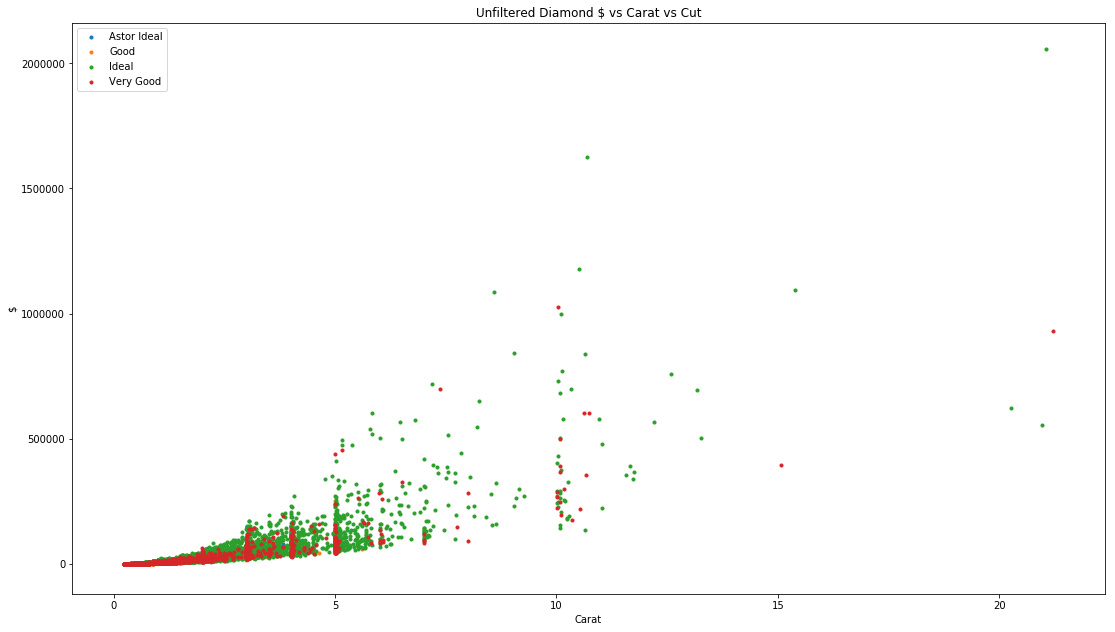

In [128]:
# full dataset
fig, ax = plt.subplots()
for c, df in diamonds5a.groupby('cut'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Unfiltered Diamond $ vs Carat vs Cut')
ax.set_xlabel('Carat')
ax.set_ylabel('$')
fig.set_size_inches(18.5, 10.5)
plt.show()


In [129]:
# narrow down to <= 5 carats since beyond this has alot less data

diamonds5b = diamonds5a.loc[(diamonds5a['carat'] <= 4.5)]
diamonds5b.describe()


,carat,price
count,140838.000000,140838.000000
mean,0.658144,3823.331927
std,0.517062,9050.689493
min,0.230000,281.000000
25%,0.330000,586.000000
50%,0.500000,1240.000000
75%,0.780000,3181.000000
max,4.500000,272018.000000


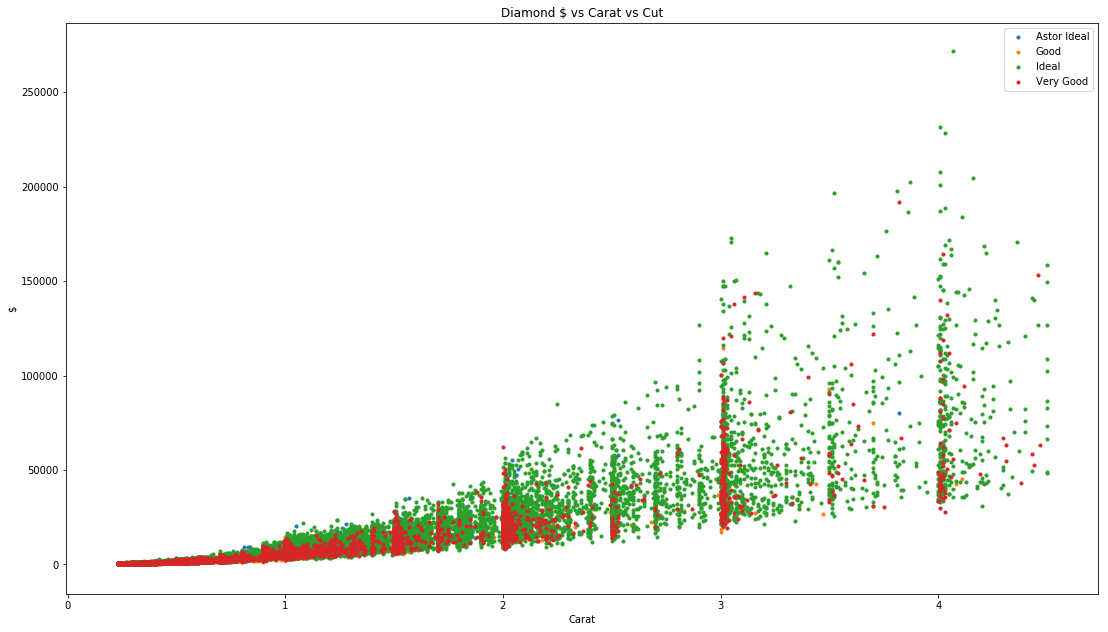

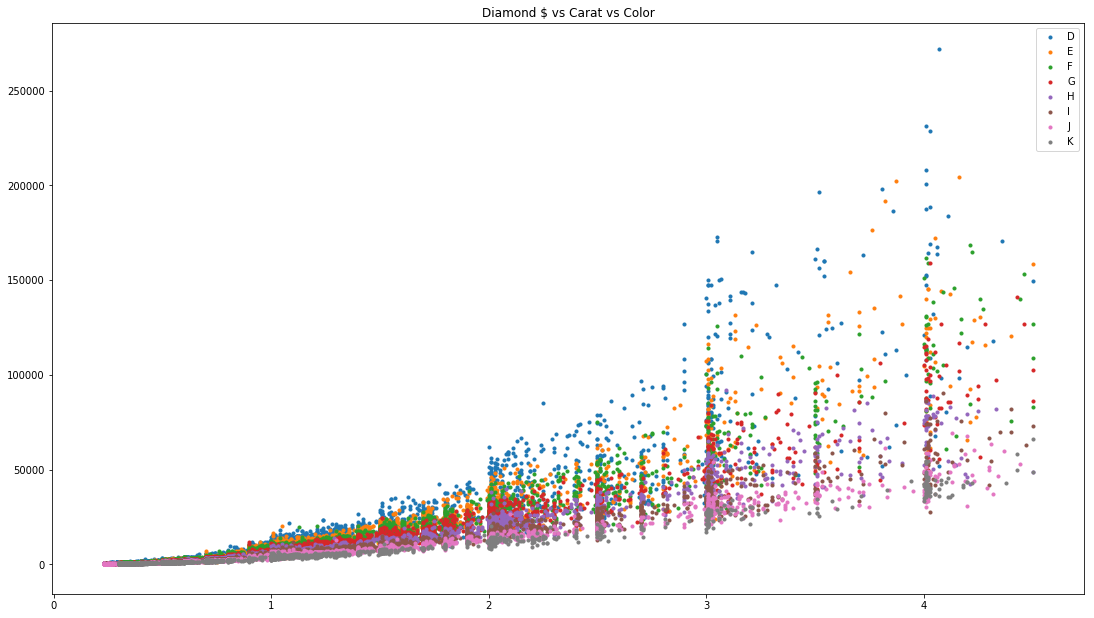

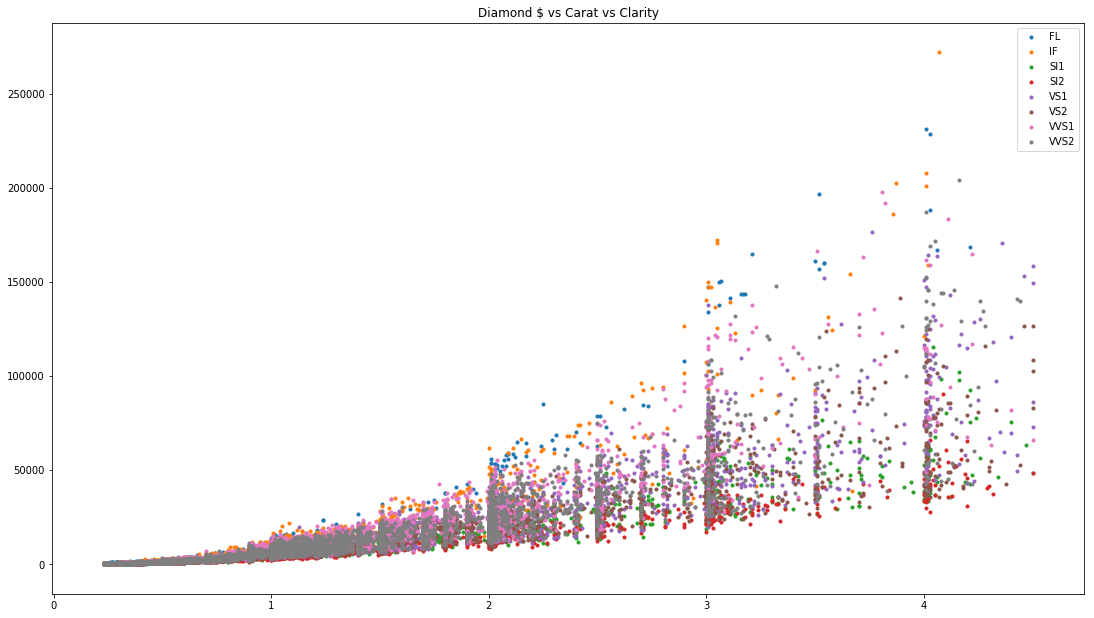

In [130]:
# scatter carat to price
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for c, df in diamonds5b.groupby('cut'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Diamond $ vs Carat vs Cut')
ax.set_xlabel('Carat')
ax.set_ylabel('$')
fig.set_size_inches(18.5, 10.5)
plt.show()

fig, ax = plt.subplots()
for c, df in diamonds5b.groupby('color'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Diamond $ vs Carat vs Color')
fig.set_size_inches(18.5, 10.5)
plt.show()

fig, ax = plt.subplots()
for c, df in diamonds5b.groupby('clarity'):
    ax.scatter(df['carat'], df['price'], label=c, s=np.pi*3)
ax.legend()
ax.set_title('Diamond $ vs Carat vs Clarity')
fig.set_size_inches(18.5, 10.5)
plt.show()



### OneHot the categoricals and build final diamonds5c set

In [131]:
cut = pd.get_dummies( diamonds5b['cut'], prefix='cut_')
color = pd.get_dummies( diamonds5b['color'], prefix='color_')
clarity = pd.get_dummies( diamonds5b['clarity'], prefix='clarity_')
diamonds5c = diamonds5b[['carat']]
diamonds5c = diamonds5c.join(cut).join(color).join(clarity)

diamonds5c.head()

,carat,cut__Astor Ideal,cut__Good,cut__Ideal,cut__Very Good,color__D,color__E,color__F,color__G,color__H,...,color__J,color__K,clarity__FL,clarity__IF,clarity__SI1,clarity__SI2,clarity__VS1,clarity__VS2,clarity__VVS1,clarity__VVS2
0,0.23,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.23,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.23,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.23,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.23,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


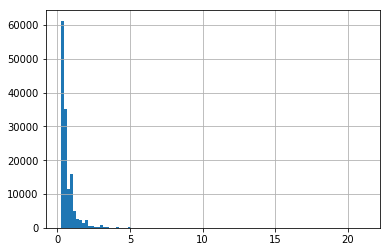

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

diamonds5a['carat'].hist(bins=100)

Text(0, 0.5, 'Number')

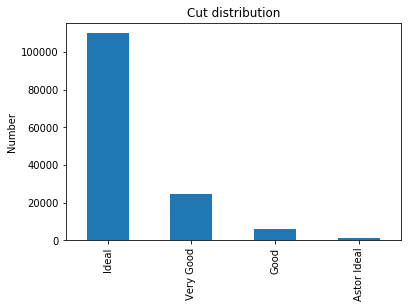

In [133]:
cuts = diamonds5a['cut'].value_counts()
cuts.plot(kind='bar')
plt.title('Cut distribution')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

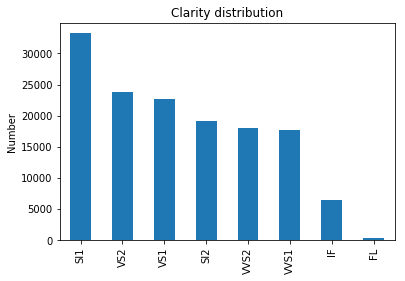

In [134]:
c = diamonds5a['clarity'].value_counts()
c.plot(kind='bar')
plt.title('Clarity distribution')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

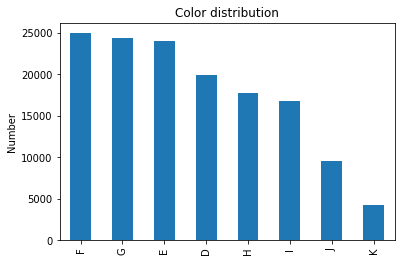

In [135]:
c = diamonds5a['color'].value_counts()
c.plot(kind='bar')
plt.title('Color distribution')
plt.ylabel('Number')

## Normalize/Scale the other input columns

In [136]:
from sklearn import preprocessing
                                            
caratDF = diamonds5a['carat'].to_frame()
scaler = preprocessing.StandardScaler().fit(caratDF)
caratDF = pd.DataFrame(scaler.transform(caratDF),columns=['caratScaled'])
diamonds5d = caratDF.join(diamonds5c) 

diamonds5d.head()

,caratScaled,carat,cut__Astor Ideal,cut__Good,cut__Ideal,cut__Very Good,color__D,color__E,color__F,color__G,...,color__J,color__K,clarity__FL,clarity__IF,clarity__SI1,clarity__SI2,clarity__VS1,clarity__VS2,clarity__VVS1,clarity__VVS2
0,-0.700519,0.23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.700519,0.23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.700519,0.23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.700519,0.23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.700519,0.23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Now ready to train a model
